# Load level 3 data

In [1]:
import json

import pandas as pd
from stellargraph import StellarGraph
import networkx as nx
import matplotlib.pyplot as plt

def create_graph(lvl_data, root):
    edges = []
    for k in  lvl_data[root].keys():
        edges.append((root, k))
        for overlap_site in lvl_data[root][k]['score']:
            edges.append((k, overlap_site['url']))

    return edges#  pd.DataFrame(edges, columns=['source', 'target'])


def draw_graph(edges=None, graph=None):
    plt.figure(num=None, figsize=(30, 28), dpi=50)

    if graph:
        nx.draw_networkx(graph.to_networkx())
    else:
        nx.draw_networkx(StellarGraph(edges=edges).to_networkx())

In [2]:
def load_level_data(level=0):
    with open(f"/home/paco/Documents/site_similarity/data/scrapping_results/processed level {level} results.json", 'r') as f:
        data = json.load(f)

    print(f'Loaded level {level} data with key size:{len(data)} values size:{sum([len(v) for v in data.values()])}')

    return data

# Define basic functions

In [3]:
lvl_one_data = load_level_data(1)

lvl_one_data.keys()

from pprint import pprint

pprint(list(lvl_one_data.keys())[:10])

Loaded level 1 data with key size:1062 values size:4837
['villagevoice.com',
 'insideclimatenews.org',
 'fury.news',
 'now8news.com',
 'constitution.com',
 'freebeacon.com',
 'brexitcentral.com',
 'foreignpolicynews.org',
 'patriotpost.us',
 'loser.com']


# Draw simple graph

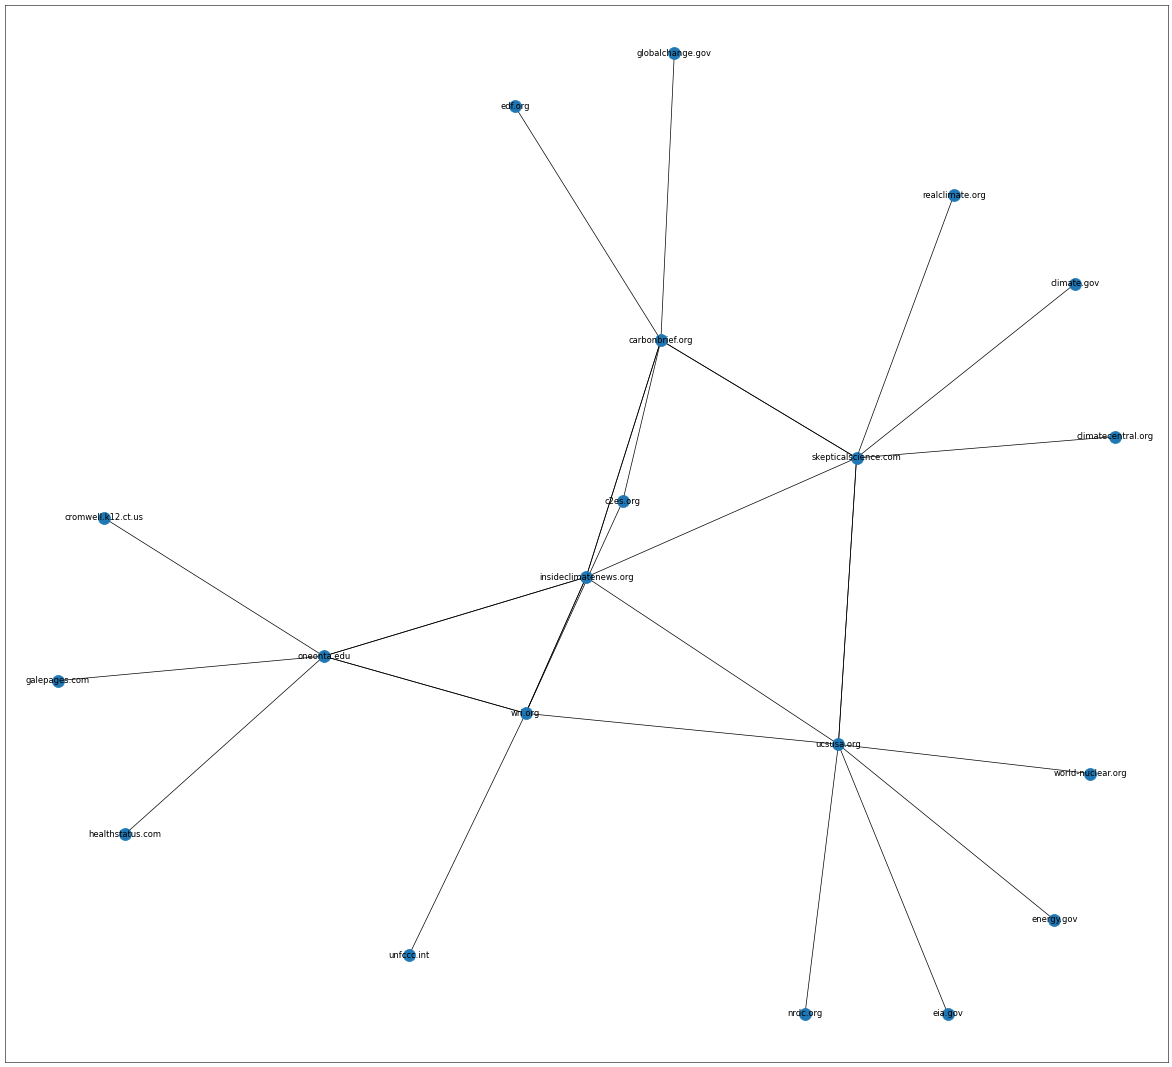

In [4]:
draw_graph(pd.DataFrame(data=create_graph(lvl_one_data, 'insideclimatenews.org'),
                        columns=['source', 'target']))

In [5]:
def create_nodes(lvl_data):
    nodes = []
    for k in list(lvl_data.keys()):
        if not lvl_data[k]:
            nodes.append((k, k))
        nodes.extend(create_graph(lvl_data, k))
    return nodes

In [6]:
res = create_nodes(lvl_one_data)

lvl_one_graph = StellarGraph(edges=pd.DataFrame(res, columns=['source', 'target']))

print(lvl_one_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 11869, Edges: 28688

 Node types:
  default: [11869]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [28688]
        Weights: all 1 (default)
        Features: none


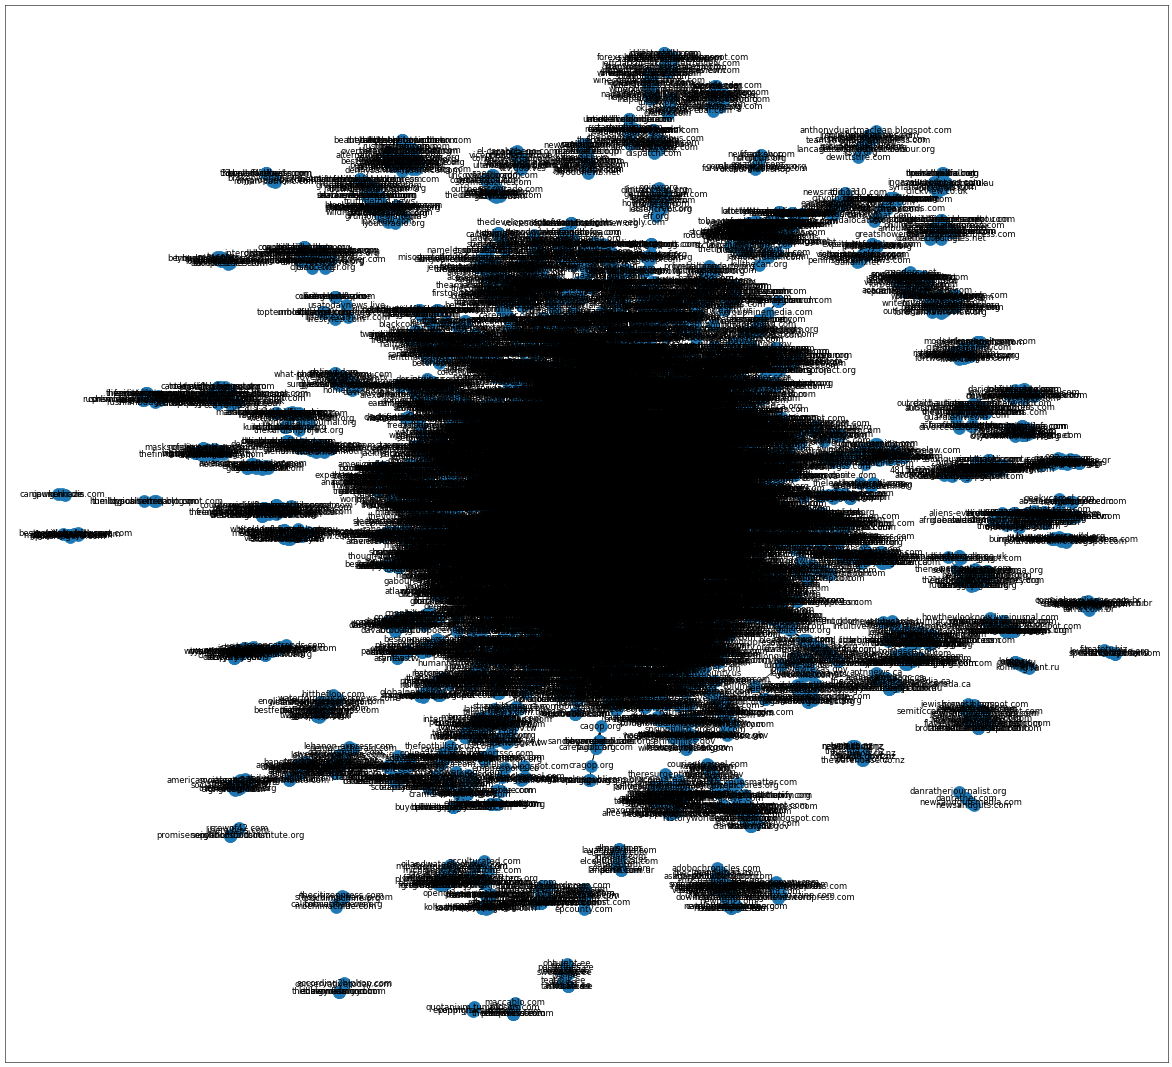

In [11]:
draw_graph(graph=lvl_one_graph)


In [15]:
from stellargraph.data import BiasedRandomWalk

rw = BiasedRandomWalk(lvl_one_graph)

walks = rw.run(
    nodes=list(lvl_one_graph.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 118690


In [8]:
from gensim.models import Word2Vec

# str_walks = [[str(n) for n in walk] for walk in walks]
# model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

# model.save("node2vec_lvl_one_data.model")

# to load model
model = Word2Vec.load("node2vec_lvl_one_data.model")

In [9]:
model.wv['villagevoice.com'].shape

(128,)

# Load data

In [13]:
import sys,os
sys.path.append("/home/paco/Documents/site_similarity")

In [14]:
from dataprep.load_annotated_data import apply_splits, load_corpus
from modelling.baselines import eval_model

DATA = load_corpus('modified_corpus.csv')
SPLITS = apply_splits(DATA)

print(SPLITS.keys())

dict_keys(['test-0', 'train-0', 'test-1', 'train-1', 'test-2', 'train-2', 'test-3', 'train-3', 'test-4', 'train-4'])


In [15]:
train = pd.DataFrame(SPLITS['train-0'])

train.head()

test = pd.DataFrame(SPLITS['test-0'])
test.head()

,source_url,source_url_processed,URL,fact,bias
0,http://foreignpolicynews.org,foreignpolicynews.org,https://mediabiasfactcheck.com/foreign-policy-...,MIXED,left
1,https://www.theatlantic.com/,theatlantic.com,http://mediabiasfactcheck.com/the-atlantic/,HIGH,left-center
2,http://liberaldarkness.com/,liberaldarkness.com,http://mediabiasfactcheck.com/liberal-darkness/,LOW,center
3,http://inthesetimes.com/,inthesetimes.com,http://mediabiasfactcheck.com/in-these-times/,HIGH,left
4,http://www.darientimes.com/,darientimes.com,https://mediabiasfactcheck.com/darien-times/,HIGH,left-center


In [16]:
X_train = train.apply(lambda x: model.wv[x['source_url_processed']], axis=1)

# Prepare train datasets

In [17]:
X_train = train.apply(lambda x: model.wv[x['source_url_processed']], axis=1)

y_train = train.apply(lambda x: x['fact'], axis=1)

print(type(X_train), type(y_train))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


# Prepare test datasets

In [18]:
X_test = test.apply(lambda x: model.wv[x['source_url_processed']], axis=1)

y_test = test.apply(lambda x: x['fact'], axis=1)

print(type(X_test), type(y_test))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


# Classifier Training

In [19]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=True, multi_class="ovr", max_iter=300
)
clf.fit(X_train.values.tolist(), y_train.values.tolist())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   29.1s finished


LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=True)

In [20]:
y_pred = clf.predict(X_test.values.tolist())

In [21]:
accuracy_score(y_test, y_pred)

0.5571428571428572

In [22]:
from sklearn.metrics import precision_score

precision_score(y_test.values.tolist(), y_pred.tolist(), average='micro')

0.5571428571428572

# Try gradient boosting tree

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(random_state=42)

In [26]:
clf.fit(X_train.tolist(), y_train.tolist())

GradientBoostingClassifier(random_state=42)

In [28]:
tree_predict = clf.predict(X_test.tolist())

In [29]:
accuracy_score(y_test, tree_predict)

0.5952380952380952

In [31]:
precision_score(y_test.values.tolist(), tree_predict, average='micro')

0.5952380952380952

# Try SVM

In [43]:
from sklearn import svm

svm_clf = svm.SVC(decision_function_shape='ovo')

In [44]:
svm_clf.fit(X_train.tolist(), y_train.tolist())

SVC(decision_function_shape='ovo')

In [45]:
svm_predict = svm_clf.predict(X_test.tolist())

In [46]:
accuracy_score(y_test, svm_predict)

0.5952380952380952

In [47]:
precision_score(y_test, svm_predict, average='micro')

0.5952380952380952

In [52]:
lin_clf = svm.LinearSVC() # one-vs-rest
lin_clf.fit(X_train.tolist(), y_train.tolist())

LinearSVC()

In [53]:
lin_predict = lin_clf.predict(X_test.tolist())

In [54]:
accuracy_score(y_test, lin_predict)

0.5285714285714286

In [59]:
precision_score(y_test, lin_predict, average='micro')

0.5285714285714286